In [1]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn

Training data shape: X=(11122, 18), y=(11122,)
Classes found: ['Good' 'Poor' 'Standard']

Training Custom Non-Linear Kernel SVM with SMO Algorithm (OvO)
Kernel: RBF (Radial Basis Function)

[1/3] Training classifier for 'Good' vs 'Poor'...
    Dataset size: 5097 samples
    Using gamma = 0.053693
    Precomputing rbf kernel matrix (5097x5097)...
    Starting SMO optimization...
    Iteration 50: 132 changed, 1870 SVs
    Iteration 100: 7 changed, 1852 SVs
    Iteration 150: 218 changed, 1976 SVs
    Iteration 200: 77 changed, 1950 SVs
    Iteration 250: 18 changed, 1947 SVs
    Iteration 300: 176 changed, 1979 SVs
    Iteration 350: 66 changed, 1974 SVs
    Iteration 400: 31 changed, 1972 SVs
    Training complete. Support vectors: 1972/5097

[2/3] Training classifier for 'Good' vs 'Standard'...
    Dataset size: 8036 samples
    Using gamma = 0.056691
    Precomputing rbf kernel matrix (8036x8036)...
    Starting SMO optimization...
    Iteration 50: 1 changed, 2789 SVs
    Iteration 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Scikit-learn SVC training completed in: 6.1951 seconds
Scikit-learn SVC Accuracy: 0.5850



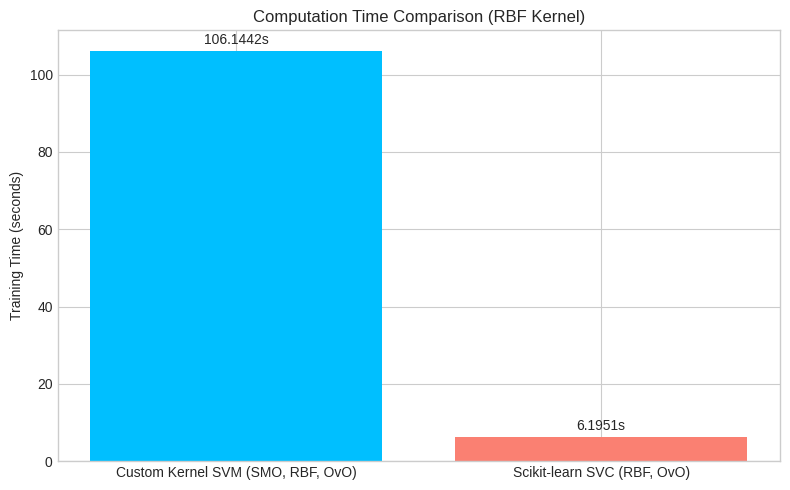


--- Generating Convergence Plot for OvO Strategy with SMO ---


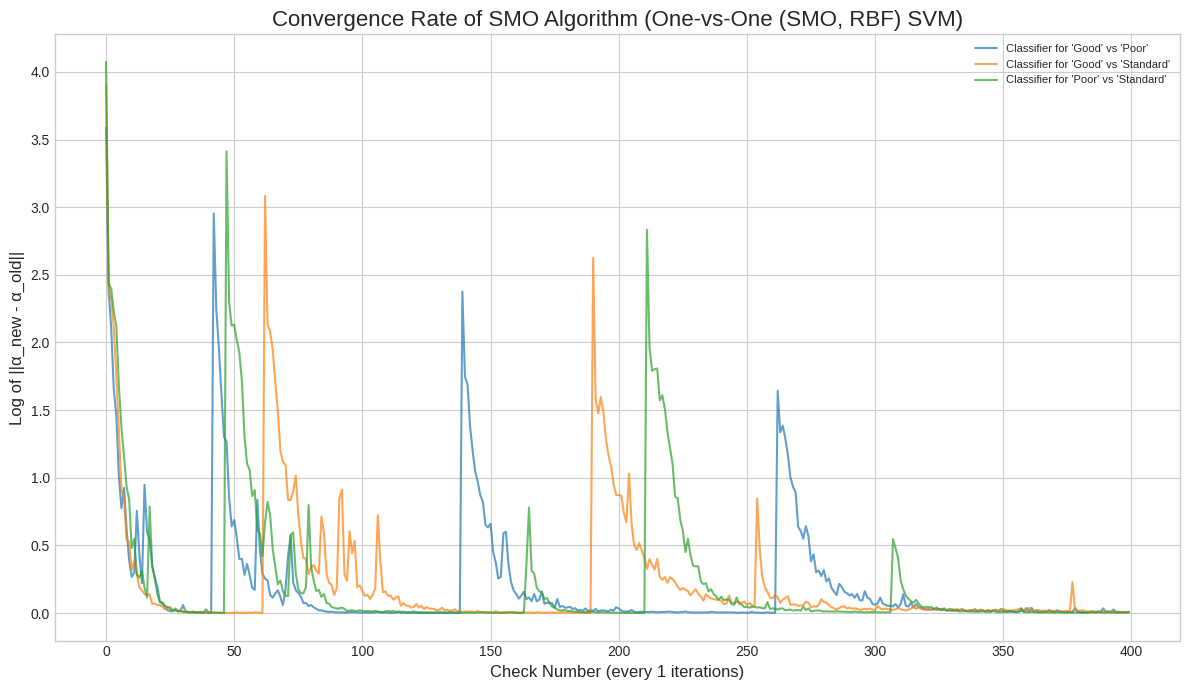


BONUS: Testing Polynomial Kernel

[1/3] Training classifier for 'Good' vs 'Poor'...
    Dataset size: 5097 samples
    Using gamma = 0.053693
    Precomputing linear kernel matrix (5097x5097)...
    Starting SMO optimization...
    Iteration 50: 493 changed, 1780 SVs
    Converged at iteration 93
    Training complete. Support vectors: 1747/5097

[2/3] Training classifier for 'Good' vs 'Standard'...
    Dataset size: 8036 samples
    Using gamma = 0.056691
    Precomputing linear kernel matrix (8036x8036)...
    Starting SMO optimization...
    Iteration 50: 498 changed, 3017 SVs
    Iteration 100: 482 changed, 2981 SVs
    Iteration 150: 480 changed, 2981 SVs
    Iteration 200: 480 changed, 2987 SVs
    Iteration 250: 462 changed, 2984 SVs
    Iteration 300: 423 changed, 2978 SVs
    Iteration 350: 437 changed, 2980 SVs
    Iteration 400: 467 changed, 2978 SVs
    Iteration 450: 432 changed, 2977 SVs
    Iteration 500: 446 changed, 2978 SVs
    Training complete. Support vectors: 297

In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import resample
from sklearn.svm import SVC # For comparison
from itertools import combinations # We will need this for OvO

# =============================================================================
# PART 1: DATA PREPROCESSING (UNCHANGED)
# =============================================================================

# convert 'Credit_History_Age' item to float
def convert_to_float(age_str):
   if isinstance(age_str, str):
       try:
           years, months = map(int, age_str.replace('Years and', '').replace('Months', '').split())
           return years + months / 12.0
       except (ValueError, AttributeError):
           return np.nan # Return NaN for malformed strings
   return age_str

# convert 'Credit_Mix' to num
credit_mix_mapping = {
   'Good': 1.0,
   'Standard': 0.5,
   'Bad': 0.0
}

# --- Load Data ---
try:
    train_data = pd.read_csv('data/train_data_l.csv')
    test_data = pd.read_csv('data/test_data.csv')
except FileNotFoundError:
    print("CSV files not found. Please ensure 'train_data_l.csv' and 'test_data.csv' are in a 'data' subdirectory.")
    try:
        train_data = pd.read_csv('train_data_m.csv')
        test_data = pd.read_csv('test_data.csv')
        print("Found CSV files in the current directory instead.")
    except FileNotFoundError:
        print("Could not find CSV files in 'data/' or the current directory. Please check file paths.")
        exit()


# --- Apply Preprocessing Functions ---
train_data['Credit_History_Age'] = train_data['Credit_History_Age'].apply(convert_to_float)
test_data['Credit_History_Age'] = test_data['Credit_History_Age'].apply(convert_to_float)
train_data['Credit_Mix'] = train_data['Credit_Mix'].map(credit_mix_mapping)
test_data['Credit_Mix'] = test_data['Credit_Mix'].map(credit_mix_mapping)

unique_behaviors = train_data['Payment_Behaviour'].dropna().unique()
behavior_mapping = {behavior: idx for idx, behavior in enumerate(unique_behaviors)}
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].map(behavior_mapping)
test_data['Payment_Behaviour'] = test_data['Payment_Behaviour'].map(behavior_mapping)

train_data = train_data.dropna()
test_data = test_data.dropna()

# --- Feature Selection and Data Splitting ---
features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
           'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
           'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
           'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
            'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Behaviour']

X_train_df = train_data[features]
y_train_df = train_data['Credit_Score']
X_test_df = test_data[features]
y_test_df = test_data['Credit_Score']

train_cols = X_train_df.columns
test_cols = X_test_df.columns
shared_cols = list(set(train_cols) & set(test_cols))
X_train_df = X_train_df[shared_cols]
X_test_df = X_test_df[shared_cols]

# --- Label Encoding and Scaling ---
le = LabelEncoder()
y_train = le.fit_transform(y_train_df)
y_test = le.transform(y_test_df)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)


# =============================================================================
# PART 2: NON-LINEAR KERNEL SVM IMPLEMENTATION WITH SMO
# =============================================================================

class KernelSVM_SMO(BaseEstimator, ClassifierMixin):
    """
    A Non-Linear Kernel Support Vector Machine classifier using Sequential Minimal Optimization (SMO).
    Supports RBF, Polynomial, and Linear kernels.
    """
    def __init__(self, C=1.0, kernel='rbf', gamma='scale', degree=3, coef0=0.0,
                 max_iter=1000, tol=1e-3, random_state=None):
        """
        Parameters:
        -----------
        C : float, default=1.0
            Regularization parameter
        kernel : str, default='rbf'
            Kernel type: 'linear', 'rbf', 'poly'
        gamma : float or 'scale' or 'auto', default='scale'
            Kernel coefficient for 'rbf' and 'poly'
            - 'scale': 1 / (n_features * X.var())
            - 'auto': 1 / n_features
        degree : int, default=3
            Degree for polynomial kernel
        coef0 : float, default=0.0
            Independent term in polynomial kernel
        max_iter : int, default=1000
            Maximum number of iterations
        tol : float, default=1e-3
            Tolerance for stopping criterion
        random_state : int or None
            Random seed
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def _compute_gamma(self, X):
        """Compute gamma value based on the setting."""
        if self.gamma == 'scale':
            return 1.0 / (X.shape[1] * X.var())
        elif self.gamma == 'auto':
            return 1.0 / X.shape[1]
        else:
            return self.gamma

    def _kernel_function(self, X1, X2):
        """
        Compute kernel matrix K(X1, X2).

        Returns:
        --------
        K : array, shape (n_samples_X1, n_samples_X2)
            Kernel matrix
        """
        if self.kernel == 'linear':
            return X1 @ X2.T

        elif self.kernel == 'rbf':
            # RBF kernel: K(x, y) = exp(-gamma * ||x - y||^2)
            # Efficient computation using: ||x - y||^2 = ||x||^2 + ||y||^2 - 2*x^T*y
            X1_norm = np.sum(X1 ** 2, axis=1).reshape(-1, 1)
            X2_norm = np.sum(X2 ** 2, axis=1).reshape(1, -1)
            distances_sq = X1_norm + X2_norm - 2 * (X1 @ X2.T)
            # Clip to avoid numerical issues with very small negative values
            distances_sq = np.clip(distances_sq, 0, None)
            return np.exp(-self.gamma_ * distances_sq)

        elif self.kernel == 'poly':
            # Polynomial kernel: K(x, y) = (gamma * x^T * y + coef0)^degree
            return (self.gamma_ * (X1 @ X2.T) + self.coef0) ** self.degree

        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def _update_error_vectorized(self, indices):
        """Update errors for specified indices using vectorized operations."""
        for i in indices:
            self.errors_[i] = np.dot(self.alphas_ * self.y_, self.K_[:, i]) + self.b_ - self.y_[i]

    def _take_step(self, i1, i2):
        """
        Optimize alpha[i1] and alpha[i2] together.
        SMO algorithm core - works the same for any kernel!
        """
        if i1 == i2:
            return 0

        alpha1 = self.alphas_[i1]
        alpha2 = self.alphas_[i2]
        y1 = self.y_[i1]
        y2 = self.y_[i2]
        E1 = self.errors_[i1]
        E2 = self.errors_[i2]
        s = y1 * y2

        # Compute L and H
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)

        if abs(L - H) < 1e-10:
            return 0

        # Compute kernel values (now using the kernel matrix)
        k11 = self.K_[i1, i1]
        k12 = self.K_[i1, i2]
        k22 = self.K_[i2, i2]

        # Compute eta
        eta = k11 + k22 - 2 * k12

        if eta <= 0:
            return 0

        # Compute new alpha2
        alpha2_new = alpha2 + y2 * (E1 - E2) / eta
        alpha2_new = np.clip(alpha2_new, L, H)

        # Check if the change is significant
        if abs(alpha2_new - alpha2) < 1e-5 * (alpha2 + alpha2_new + 1e-5):
            return 0

        # Update alpha1
        alpha1_new = alpha1 + s * (alpha2 - alpha2_new)

        # Store old values
        delta_alpha1 = alpha1_new - alpha1
        delta_alpha2 = alpha2_new - alpha2

        # Update threshold b
        b1 = self.b_ - E1 - y1 * delta_alpha1 * k11 - y2 * delta_alpha2 * k12
        b2 = self.b_ - E2 - y1 * delta_alpha1 * k12 - y2 * delta_alpha2 * k22

        b_old = self.b_

        if 0 < alpha1_new < self.C:
            self.b_ = b1
        elif 0 < alpha2_new < self.C:
            self.b_ = b2
        else:
            self.b_ = (b1 + b2) / 2.0

        delta_b = self.b_ - b_old

        # Update alphas
        self.alphas_[i1] = alpha1_new
        self.alphas_[i2] = alpha2_new

        # Vectorized error cache update
        if abs(delta_alpha1) > 1e-10 or abs(delta_alpha2) > 1e-10:
            self.errors_ += (delta_alpha1 * y1 * self.K_[:, i1] +
                           delta_alpha2 * y2 * self.K_[:, i2] + delta_b)
            self._update_error_vectorized([i1, i2])

        return 1

    def _examine_example(self, i2):
        """
        Examine if alpha[i2] violates KKT conditions.
        Optimized version with early exits.
        """
        y2 = self.y_[i2]
        alpha2 = self.alphas_[i2]
        E2 = self.errors_[i2]
        r2 = E2 * y2

        # Check KKT conditions
        if not ((r2 < -self.tol and alpha2 < self.C) or
                (r2 > self.tol and alpha2 > 0)):
            return 0

        # Find non-bound alphas
        non_bound_mask = (self.alphas_ > 0) & (self.alphas_ < self.C)

        # Heuristic 1: Choose i1 to maximize |E1 - E2|
        if np.any(non_bound_mask):
            if E2 > 0:
                i1 = np.argmin(self.errors_)
            else:
                i1 = np.argmax(self.errors_)

            if self._take_step(i1, i2):
                return 1

            # Heuristic 2: Loop through non-bound examples
            non_bound_indices = np.where(non_bound_mask)[0]
            if len(non_bound_indices) > 0:
                self.rng_.shuffle(non_bound_indices)
                for i1 in non_bound_indices[:min(100, len(non_bound_indices))]:
                    if self._take_step(i1, i2):
                        return 1

        # Heuristic 3: Try a random subset of all examples
        all_indices = np.arange(self.n_samples_)
        sample_size = min(100, self.n_samples_)
        sample_indices = self.rng_.choice(all_indices, size=sample_size, replace=False)
        for i1 in sample_indices:
            if self._take_step(i1, i2):
                return 1

        return 0

    def fit(self, X, y):
        """Fit the SVM model using SMO algorithm with kernel trick."""
        X, y = check_X_y(X, y)
        if not np.all(np.isin(y, [-1, 1])):
            raise ValueError("Labels must be -1 or 1 for this binary implementation.")

        # Store training data (needed for kernel computation)
        self.X_ = X.astype(np.float32)
        self.y_ = y.astype(np.float32)
        self.n_samples_, self.n_features_ = X.shape

        # Compute gamma
        self.gamma_ = self._compute_gamma(X)
        print(f"    Using gamma = {self.gamma_:.6f}")

        # Initialize alphas and b
        self.alphas_ = np.zeros(self.n_samples_, dtype=np.float32)
        self.b_ = 0.0

        # Precompute kernel matrix K(X, X)
        print(f"    Precomputing {self.kernel} kernel matrix ({self.n_samples_}x{self.n_samples_})...")
        self.K_ = self._kernel_function(self.X_, self.X_).astype(np.float32)

        # Initialize error cache
        self.errors_ = -self.y_.copy()

        # Random number generator
        self.rng_ = np.random.RandomState(self.random_state)

        # Convergence tracking
        self.convergence_history_ = []

        num_changed = 0
        examine_all = True
        iter_num = 0

        print(f"    Starting SMO optimization...")

        check_interval = 1
        no_change_count = 0

        while iter_num < self.max_iter:
            num_changed = 0

            if iter_num % check_interval == 0:
                old_alphas = self.alphas_.copy()

            if examine_all:
                for i in range(self.n_samples_):
                    num_changed += self._examine_example(i)
            else:
                non_bound_indices = np.where((self.alphas_ > 0) & (self.alphas_ < self.C))[0]

                if len(non_bound_indices) > 500:
                    non_bound_indices = self.rng_.choice(
                        non_bound_indices,
                        size=500,
                        replace=False
                    )

                for i in non_bound_indices:
                    num_changed += self._examine_example(i)

            # Track convergence
            if iter_num % check_interval == 0:
                diff = np.linalg.norm(self.alphas_ - old_alphas)
                self.convergence_history_.append(diff)

                if diff < self.tol:
                    no_change_count += 1
                    if no_change_count >= 3:
                        print(f"    Converged at iteration {iter_num}")
                        break
                else:
                    no_change_count = 0

            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True

            iter_num += 1

            if iter_num % 50 == 0:
                n_sv = np.sum(self.alphas_ > 1e-5)
                print(f"    Iteration {iter_num}: {num_changed} changed, {n_sv} SVs")

        # Store support vectors (for prediction)
        sv_mask = self.alphas_ > 1e-5
        self.support_vectors_ = self.X_[sv_mask]
        self.support_vector_labels_ = self.y_[sv_mask]
        self.support_vector_alphas_ = self.alphas_[sv_mask]

        n_support = np.sum(sv_mask)
        print(f"    Training complete. Support vectors: {n_support}/{self.n_samples_}")

        self.is_fitted_ = True

        # Clean up kernel matrix to save memory
        del self.K_
        del self.errors_

        return self

    def decision_function(self, X):
        """
        Compute decision function for samples in X.
        f(x) = sum_{i in SV} alpha_i * y_i * K(x_i, x) + b
        """
        check_is_fitted(self)
        X = check_array(X)

        # Compute kernel between test samples and support vectors
        K_test = self._kernel_function(X, self.support_vectors_)

        # Decision function
        decision = np.dot(K_test, self.support_vector_alphas_ * self.support_vector_labels_) + self.b_

        return decision

    def predict(self, X):
        """Predict class labels for samples in X."""
        scores = self.decision_function(X)
        return np.sign(scores).astype(int)


# =============================================================================
# PART 3: ONE-vs-ONE WRAPPER (UNCHANGED)
# =============================================================================

class MultiClassSVM_OvO(BaseEstimator, ClassifierMixin):
    """
    A multi-class classifier using the One-vs-One (OvO) strategy.
    """
    def __init__(self, base_estimator, **estimator_params):
        self.base_estimator = base_estimator
        self.estimator_params = estimator_params

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.class_mapping_ = {label: i for i, label in enumerate(self.classes_)}

        # Generate all unique pairs of classes
        self.class_pairs_ = list(combinations(self.classes_, 2))

        self.estimators_ = {}
        self.convergence_histories_ = []
        self.convergence_labels_ = []

        # Iterate over each pair of classes
        for idx, (class1, class2) in enumerate(self.class_pairs_):
            class1_name = le.classes_[class1]
            class2_name = le.classes_[class2]
            print(f"\n[{idx+1}/{len(self.class_pairs_)}] Training classifier for '{class1_name}' vs '{class2_name}'...")

            # Filter the data
            pair_indices = np.where((y == class1) | (y == class2))
            X_pair = X[pair_indices]
            y_pair = y[pair_indices]

            print(f"    Dataset size: {X_pair.shape[0]} samples")

            # Create binary labels
            y_binary = np.where(y_pair == class1, 1, -1)

            # Train binary SVM
            estimator = self.base_estimator(**self.estimator_params)
            estimator.fit(X_pair, y_binary)

            # Store estimator
            self.estimators_[(class1, class2)] = estimator

            # Store convergence history
            self.convergence_histories_.append(estimator.convergence_history_)
            self.convergence_labels_.append(f"'{class1_name}' vs '{class2_name}'")

        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        # Initialize votes matrix
        votes = np.zeros((n_samples, n_classes))

        # Let each binary classifier vote
        for (class1, class2), estimator in self.estimators_.items():
            predictions = estimator.predict(X)

            idx1 = self.class_mapping_[class1]
            idx2 = self.class_mapping_[class2]

            votes[predictions == 1, idx1] += 1
            votes[predictions == -1, idx2] += 1

        # Final prediction
        highest_vote_indices = np.argmax(votes, axis=1)
        return self.classes_[highest_vote_indices]

# =============================================================================
# PART 4: ANALYSIS AND PLOTTING FUNCTIONS
# =============================================================================

def plot_convergence(histories, plot_labels, svm_type="One-vs-One"):
    """Plots the convergence rate of the SMO algorithm for each OvO classifier."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    for i, history in enumerate(histories):
        if len(history) > 0:
            ax.plot(np.log1p(history), label=f'Classifier for {plot_labels[i]}', alpha=0.7)

    ax.set_title(f'Convergence Rate of SMO Algorithm ({svm_type} SVM)', fontsize=16)
    ax.set_xlabel('Check Number (every 1 iterations)', fontsize=12)
    ax.set_ylabel('Log of ||α_new - α_old||', fontsize=12)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# =============================================================================
# PART 5: MAIN EXECUTION BLOCK
# =============================================================================

if __name__ == '__main__':
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Classes found: {le.classes_}")

    # --- 1. ACCURACY AND COMPUTATION TIME WITH RBF KERNEL ---
    print("\n" + "="*60)
    print("Training Custom Non-Linear Kernel SVM with SMO Algorithm (OvO)")
    print("Kernel: RBF (Radial Basis Function)")
    print("="*60)

    # Instantiate the multi-class wrapper with RBF kernel SVM
    multi_svm_ovo = MultiClassSVM_OvO(
        base_estimator=KernelSVM_SMO,
        # C=10.0,              # Increased C for better fit
        C=1.0,              # Increased C for better fit
        kernel='rbf',        # RBF kernel
        gamma='scale',       # Auto-compute gamma
        # gamma=1,       # Auto-compute gamma
        max_iter=500,
        tol=1e-3,
        random_state=42
    )

    start_time = time.perf_counter()
    multi_svm_ovo.fit(X_train, y_train)
    end_time = time.perf_counter()
    custom_svm_time = end_time - start_time

    y_pred = multi_svm_ovo.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)

    print(f"\nTraining completed in: {custom_svm_time:.4f} seconds")
    print(f"\nAccuracy on Test Set: {accuracy:.4f}\n")
    print("Classification Report:")
    print(report)

    # --- COMPARISON WITH SKLEARN's RBF SVC ---
    print("\n" + "="*60)
    print("Training Scikit-learn's SVC with RBF Kernel for Comparison")
    print("="*60)
    sklearn_svc = SVC(kernel='poly', C=1.0, gamma='scale', max_iter=5000,
                      random_state=42, decision_function_shape='ovo')

    start_time_sklearn = time.perf_counter()
    sklearn_svc.fit(X_train, y_train)
    end_time_sklearn = time.perf_counter()
    sklearn_time = end_time_sklearn - start_time_sklearn

    y_pred_sklearn = sklearn_svc.predict(X_test)
    accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

    print(f"Scikit-learn SVC training completed in: {sklearn_time:.4f} seconds")
    print(f"Scikit-learn SVC Accuracy: {accuracy_sklearn:.4f}\n")

    # --- TIME PLOT ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 5))
    models = ['Custom Kernel SVM (SMO, RBF, OvO)', 'Scikit-learn SVC (RBF, OvO)']
    times = [custom_svm_time, sklearn_time]
    ax.bar(models, times, color=['deepskyblue', 'salmon'])
    ax.set_ylabel('Training Time (seconds)')
    ax.set_title('Computation Time Comparison (RBF Kernel)')
    for i, v in enumerate(times):
        ax.text(i, v + 0.01 * max(times), f"{v:.4f}s", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # --- 2. CONVERGENCE RATE PLOT ---
    print("\n--- Generating Convergence Plot for OvO Strategy with SMO ---")
    plot_convergence(
        multi_svm_ovo.convergence_histories_,
        multi_svm_ovo.convergence_labels_,
        svm_type="One-vs-One (SMO, RBF)"
    )

    # --- OPTIONAL: TEST WITH POLYNOMIAL KERNEL ---
    print("\n" + "="*60)
    print("BONUS: Testing Polynomial Kernel")
    print("="*60)

    multi_svm_poly = MultiClassSVM_OvO(
        base_estimator=KernelSVM_SMO,
        C=1.0,
        kernel='poly',
        degree=3,
        gamma='scale',
        coef0=1.0,
        max_iter=500,
        tol=1e-3,
        random_state=42
    )

    start_time_poly = time.perf_counter()
    multi_svm_poly.fit(X_train, y_train)
    end_time_poly = time.perf_counter()
    poly_time = end_time_poly - start_time_poly

    y_pred_poly = multi_svm_poly.predict(X_test)
    accuracy_poly = accuracy_score(y_test, y_pred_poly)

    print(f"\nPolynomial Kernel SVM Training Time: {poly_time:.4f} seconds")
    print(f"Polynomial Kernel SVM Accuracy: {accuracy_poly:.4f}\n")